<a href="https://colab.research.google.com/github/wlehddl/wlehddl.github.io/blob/main/lsmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
currnet dir =  /content/gdrive/My Drive/Colab Notebooks/dataset


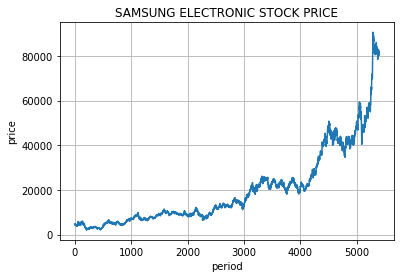

Volume <class 'str'>
Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 116
3MA: 0
5MA: 0
Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 0
5MA: 0
          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.034868  0.032008  0.036288  0.034440   0.026655  0.025192  0.025698   
1     0.037375  0.035517  0.038470  0.034440   0.026655  0.025634  0.025094   
2     0.034982  0.031689  0.036518  0.033873   0.026217  0.026163  0.025343   
3     0.034868  0.031689  0.036059  0.033760   0.026129  0.025987  0.025503   
4     0.036235  0.033177  0.037437  0.035120   0.027181  0.026163  0.026018   
...        ...       ...       ...       ...        ...       ...       ...   
5264  0.891750  0.830923  0.896647  0.881047   0.885878  0.895299  0.903144   
5265  0.892890  0.834113  0.897795  0.885578   0.890399  0.894920  0.900854   
5266  0.899727  0.841557  0.903537  0.895774   0.900571  0.897955  0.902457   
5267  0.895169  0.835177  0.89894

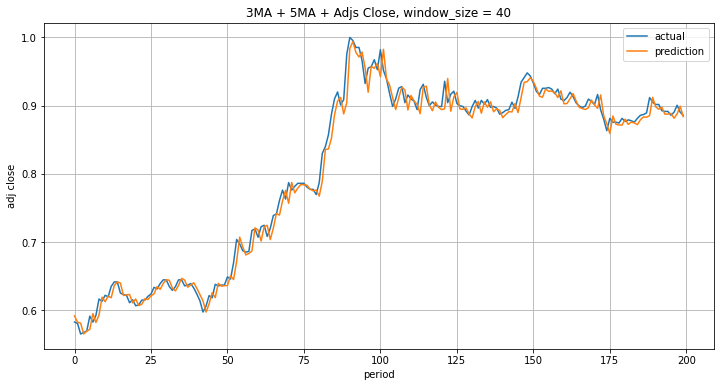

0.012565626212465993


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from google.colab import drive

drive.mount('/content/gdrive/')

#[2] Google Drive 내의 working directory 이동
import os

working_dir = 'dataset'

colab_default_dir = '/content/gdrive/My Drive/Colab Notebooks'

original_dir = os.getcwd()

try:
  os.chdir(colab_default_dir) #Google Drive의 Colab 기본 디렉토리로 이동

  if not os.path.exists(working_dir):
    os.mkdir(working_dir)

  os.chdir(working_dir) #Working 디렉토리로 이동
  print('currnet dir = ', os.getcwd())

except Exception as err:
  os.chdir(original_dir)
  print(str(err))

#데이터 불러오기
raw_df = pd.read_csv('./005930.KS_3MA_5MA.csv')
raw_df.head()

plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['Adj Close'], label = 'Adj Close')

plt.show()

#데이터 전처리(Missing Data 처리, 정규화 등)
raw_df.describe()

#Missing Data 확인
raw_df.isnull().sum() #공휴일이나 휴일 등 거래가 열리지않는 날인 "0.000000e+00"과 같은 missing value를 찾음

#최소값이 0인 column 체크
for col in raw_df.columns:
  if raw_df[col].min() == 0:
    col_name = col
    print(col_name, type(col_name))

raw_df.loc[raw_df['Volume']==0]

#각 column에 0 몇개인지 확인
for col in raw_df.columns:
  missing_rows = raw_df.loc[raw_df[col] == 0].shape[0]
  print(col + ': ' + str(missing_rows))

#먼저 0을 NaN으로 바꾼 후, Missing Data 처리
raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan) #0값을 NaN으로 대체

#0->NaN으로 replace 후 각 column에 0 몇개인지 확인
for col in raw_df.columns:
  missing_rows = raw_df.loc[raw_df[col] == 0].shape[0]
  print(col + ': ' + str(missing_rows))

#missing data 확인
raw_df.isnull().sum()

raw_df.isnull().any()

raw_df.loc[raw_df['Open'].isna()] #missing value 행 전체 보여주기

#missing data 처리
raw_df = raw_df.dropna() #missing value 행 전체 삭제
raw_df.isnull().sum() #missing value 행 삭제 후 삭제 확인

#정규화 (Data 제외한 모든 수치부분 정규화)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', '3MA', '5MA', 'Volume'] #정규화 대상 column 정의
scaled_df = scaler.fit_transform(raw_df[scaler_cols]) #정규화 수행
scaled_df = pd.DataFrame(scaled_df, columns = scaler_cols) #정규화된 새로운 DataFrame 생성
print(scaled_df)

#주가예측을 위해 3MA, 5MA, Adj Close 항목을 feature 선정
#정답은 Adj Close 선정
#시계열 데이터를 위한 window_size = 40 선정
def make_sequene_dataset(feature, label, window_size):
  feature_list = []   #생성될 feature list
  label_list = []     #생성될 label list

  for i in range(len(feature) - window_size):
    feature_list.append(feature[i:i+window_size]) #슬라이싱을 이용하여 window size에 맞게 행렬의 형태로 만듦
    label_list.append(label[i+window_size])

  return np.array(feature_list), np.array(label_list) #2차원 행렬에 대해서 numpy 형식으로 만들어주면 3차원 Tensor로 변환됨

#feature_df, label_df 생성
feature_cols = ['3MA', '5MA', 'Adj Close'] #입력데이터를 나타내는 feature column 정의
label_cols = ['Adj Close'] #정답데이터를 나타내는 label column 정의

feature_df = pd.DataFrame(scaled_df, columns = feature_cols)
label_df = pd.DataFrame(scaled_df, columns = label_cols)

#DataFrame => Numpy 변환
feature_np = feature_df.to_numpy() #딥러닝 학습을 위해 DataFrame => numpy 변환
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

#시계열 데이터 생성 (make_Sequence_dataset)
window_size = 40 #40개의 데이터
X, Y = make_sequene_dataset(feature_np, label_np, window_size)
print(X.shape, Y.shape)

#학습 데이터, 테스트 데이터 생성
#train, test 분리
#split = int(len(X)*0.95)
split = -200
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

#모델 구축 및 컴파일
#model 생성
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape = x_train[0].shape)) #LSTM 계층에 tanh를 활성화 함수로 갖는 노드 수 128개 / input_size = (40, 3)
model.add(Dense(1, activation = 'linear')) #1개의 노드를 가지는 출력층

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
model.summary()

#모델 학습(EarlyStopping 적용)
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

model.fit(x_train, y_train,
          validation_data = (x_test, y_test),
          epochs = 100, batch_size = 16,
          callbacks = [early_stop])

#예측을 통한 정답과의 비교(오차계산 MAPE 사용, 평균절대값백분율오차)
pred = model.predict(x_test)

plt.figure(figsize = (12, 6))
plt.title('3MA + 5MA + Adjs Close, window_size = 40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.grid()
plt.legend(loc = 'best')

plt.show()

#평균절대값백분율오차계산 (MAPE)
print(np.sum(abs(y_test-pred) / y_test) / len(x_test))
